In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
from astropy.io import fits

In [3]:
figsize(8,6)

In [4]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p, hits, ra_bins, dec_bins

In [67]:
fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_05_*C*.rfireduced_new.npz')
fnames.sort()

In [68]:
calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_05_C.npy').item()
fdiode = calibrations['freqs']
pdiode = calibrations['pdiode']
pdiode1 = calibrations['pdiode1']
meanpower = 0.5 * (pdiode + pdiode1)

In [69]:
nz = np.load(fnames[0])
ra = nz['sra']
dec = nz['sdec']
mask = nz['valid']
az = nz['AZIMUTH'][::8]
el = nz['ELEVATIO'][::8]
freqs = nz['freqs']

gain = meanpower / ( nz['xxon'] - nz['xxoff'])
calibd = nz['xxoff'] * gain

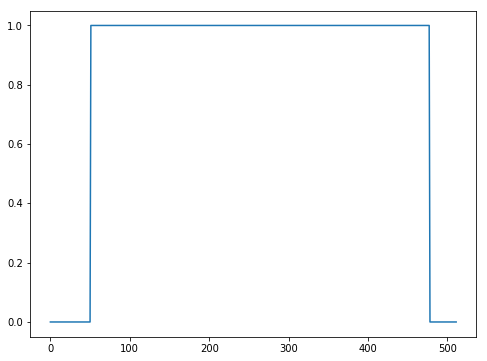

In [70]:
plot(mask)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


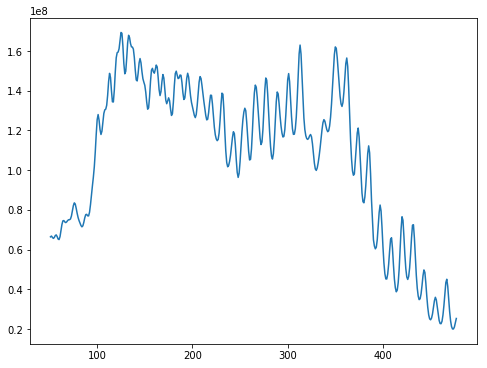

In [71]:
plot(np.nanmean(nz['xxon'], 0))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


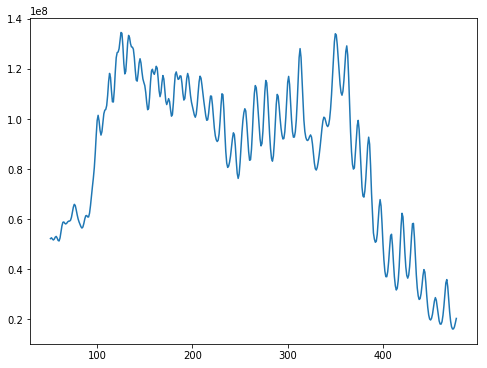

In [72]:
plot(np.nanmean(nz['xxoff'], 0))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


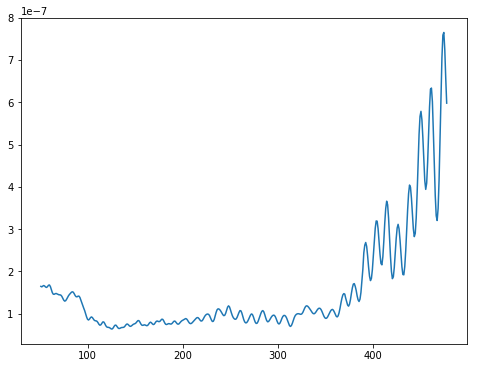

In [73]:
plot(np.nanmean(gain, 0))

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


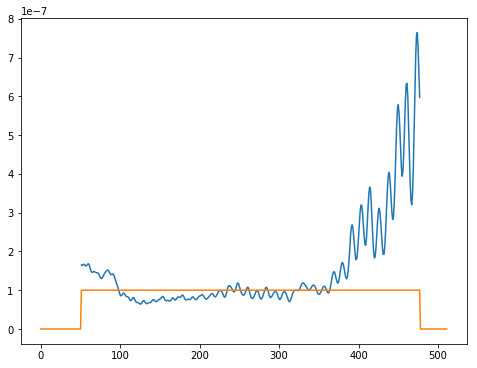

In [74]:
plot(np.arange(512), np.nanmean(gain, 0))
plot(mask * 1.e-7)

In [66]:
# cut off A below 160, same with B 
# cut 
# or just keep only 200-400

In [37]:
def get_data(bank="A", session=5):
    fnames = glob.glob('/data2/GBT/S140/Daisy/*/*_0'+str(session)+'_*'+bank+'*.rfireduced_new.npz')
    fnames.sort()
    calibrations = np.load('/home/mabitbol/GBT-S140/calibrations/calibration_3C295_05_'+bank+'.npy').item()
    fdiode = calibrations['freqs']
    pdiode = calibrations['pdiode']
    pdiode1 = calibrations['pdiode1']
    meanpower = 0.5 * (pdiode + pdiode1)
    calibrated = [] 
    ras = []
    decs = []
    meansub = []
    azs = []
    els = []
    gains = None
    for fname in fnames:
        nz = np.load(fname)
        ra = nz['sra']
        dec = nz['sdec']
        mask = nz['valid']
        az = nz['AZIMUTH'][::8]
        el = nz['ELEVATIO'][::8]
        freqs = nz['freqs']
            
        gain = meanpower / ( nz['xxon'] - nz['xxoff'])
        calibd = nz['xxoff'] * gain
        #calibd = calibd[:, mask]

        calibrated = np.concatenate([calibrated, np.nanmean(calibd - np.nanmedian(calibd,0), 1)])
        meansub = np.concatenate([meansub, np.nanmean(calibd,1) - np.nanmedian(np.nanmean(calibd,1))])
        ras = np.concatenate([ras, ra])
        decs = np.concatenate([decs, dec])
        azs = np.concatenate([azs, az])
        els = np.concatenate([els, el])
        if gains is None:
            gains = gain
        else:
            gains = np.concatenate([gains, gain])
    return calibrated, meansub, ras, decs, azs, els, gains

In [10]:
def get_maps(bank='A', session=5, doplot=True, dosave=True):
    calibrated, meansub, ras, decs, azs, els, gains = get_data(bank, session)
    
    tmask = np.ones(len(calibrated), dtype=bool)
    if bank == 'A':
        ts = np.arange(len(calibrated))
        tmask = (ts < 42000) | (ts > 50000 )
        
    if bank == 'A':
        cfreq = 4.575
    elif bank == 'B':
        cfreq = 5.625
    elif bank == 'C':
        cfreq = 6.125
    elif bank == 'D':
        cfreq = 7.175
    beam = 12.6 / cfreq
    rapix = int((ras.max() - ras.min()) / (beam / 60.))
    decpix = int((decs.max() - decs.min()) / (beam / 60.))
    
    datamap, hits, rabins, decbins = naive_map(calibrated[tmask], ras[tmask], decs[tmask], rapix, decpix)
    mask = hits == 0
    signal = datamap / hits
    signal[mask] = np.nan
    
    varmap = np.nanstd(calibrated[tmask])/np.sqrt(hits)
    mask = hits == 0
    varmap[mask] = np.nan
    
    if doplot:
        figure()
        plot(calibrated)
        ylim(-1, 1)

        figure()
        pc = pcolormesh(rabins, decbins, signal.T)
        clim(-0.1, 0.1)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Flux [Jy]')

        figure()
        pc = pcolormesh(rabins, decbins, hits.T)
        clim(1, 40)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Hits')

        figure()
        pc = pcolormesh(rabins, decbins, varmap.T)
        clim(0, 0.02)
        cb = colorbar()
        xlabel('RA [degrees]')
        ylabel('DEC [degrees]')
        cb.set_label('Sqrt Variance [Jy]')
    
    if dosave:
        z = {'rabins': rabins, 'decbins':decbins, 'signal':signal.T, 'hits':hits.T, 'weight':varmap.T}
        np.savez('/home/mabitbol/GBT-S140/datamaps/datamaps_'+bank+'_'+str(session), **z)
    return calibrated, gains

In [11]:
calibrated, gain = get_maps('A', 5, False)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(1.75e-07, 2.25e-07)

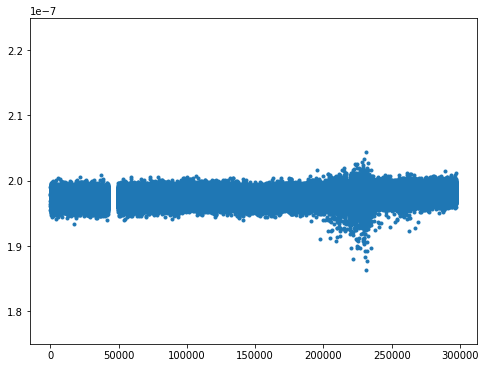

In [25]:
plot(np.nanmean(gain, 1), '.')
ylim(1.75e-7, 2.25e-7)

In [34]:
calibrated, gain = get_maps('B', 5, False)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


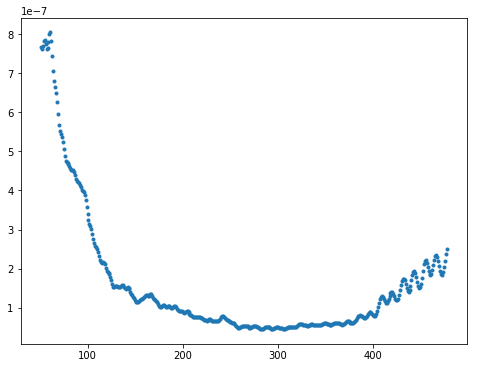

In [35]:
plot(np.nanmean(gain, 0), '.')
#ylim(1.75e-7, 2.25e-7)

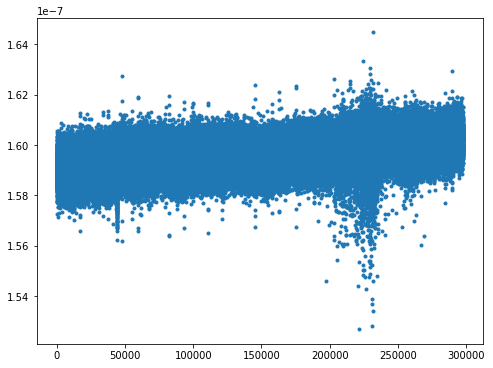

In [28]:
plot(np.nanmean(gain, 1), '.')
#ylim(1.75e-7, 2.25e-7)

In [29]:
calibrated, gain = get_maps('C', 5, False)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in divide


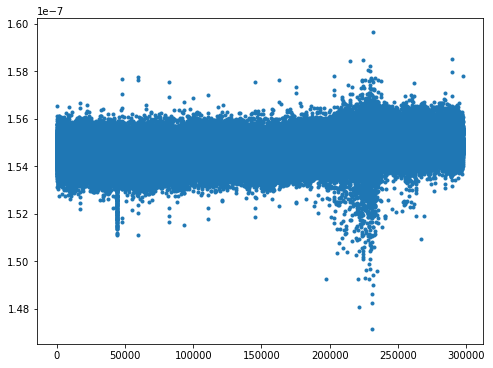

In [30]:
plot(np.nanmean(gain, 1), '.')
#ylim(1.75e-7, 2.25e-7)

In [31]:
calibrated, gain = get_maps('D', 5, False)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/usr/lib64/python2.7/site-packages/numpy/lib/nanfunctions.py:1304: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


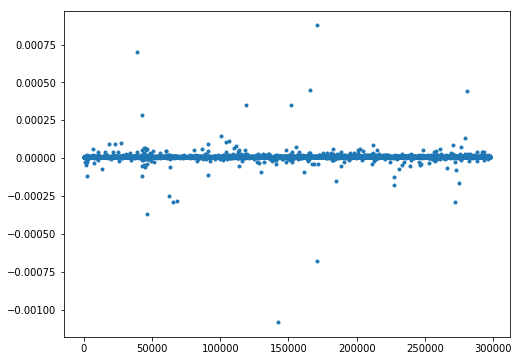

In [32]:
plot(np.nanmean(gain, 1), '.')
#ylim(1.75e-7, 2.25e-7)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


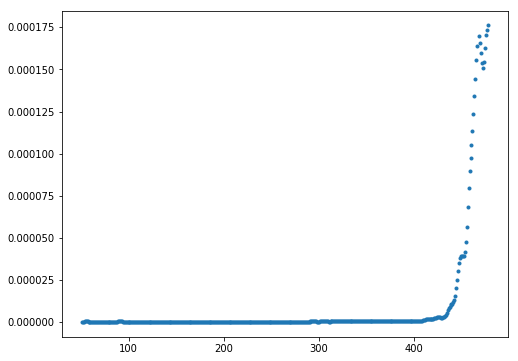

In [33]:
plot(np.nanmean(gain, 0), '.')
#ylim(1.75e-7, 2.25e-7)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


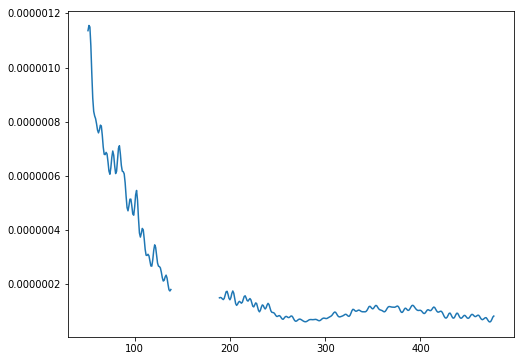

In [14]:
plot(np.nanmean(gain, 0))

In [12]:
gain.shape

(7153, 512)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


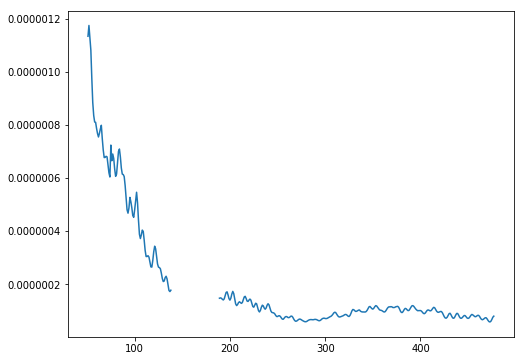

In [18]:
plot(np.nanmean(gain[42000:48000,:], 0))

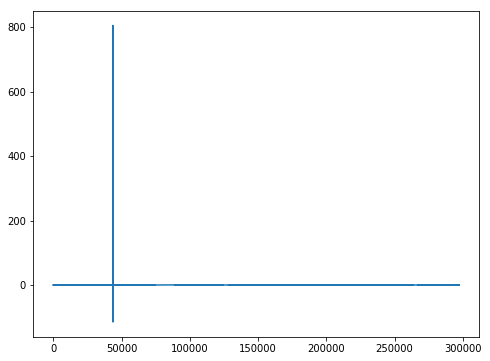

In [9]:
plot(calibrated)

In [10]:
np.nanstd(calibrated)

1.5495677182904803

In [14]:
bad = np.abs(calibrated) > 5. * np.nanstd(calibrated[~bad])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


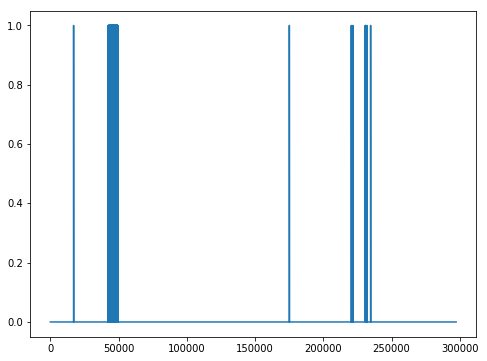

In [15]:
plot(bad)

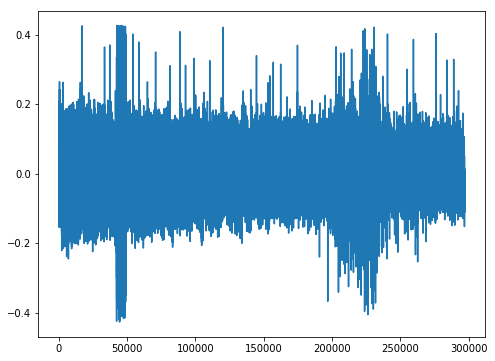

In [16]:
plot(calibrated[~bad])

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


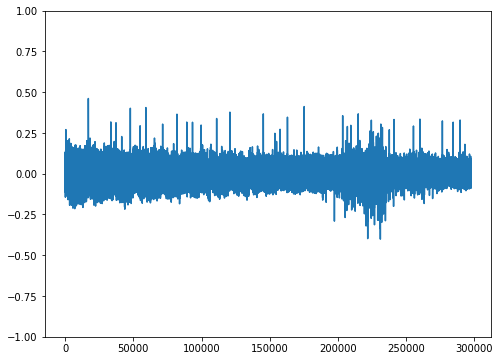

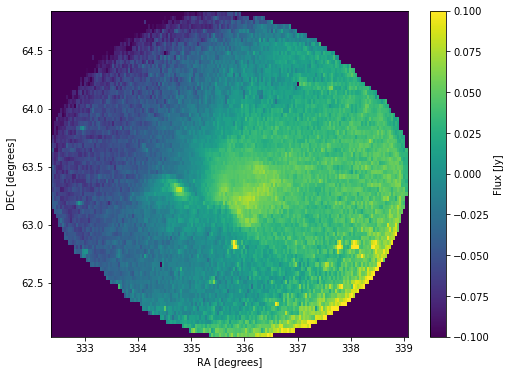

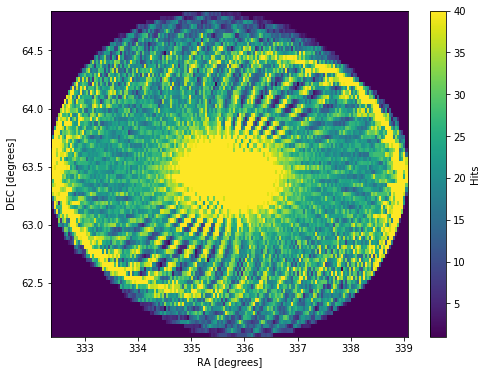

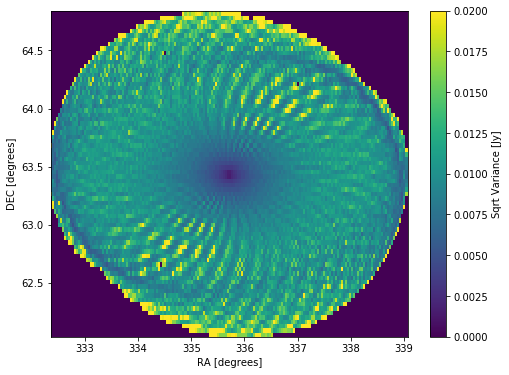

In [19]:
rabins, decbins, signal, hits, varmap = get_maps('B', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


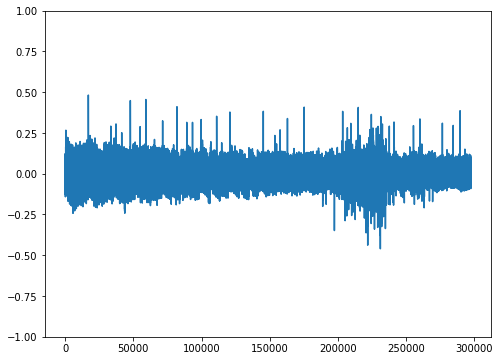

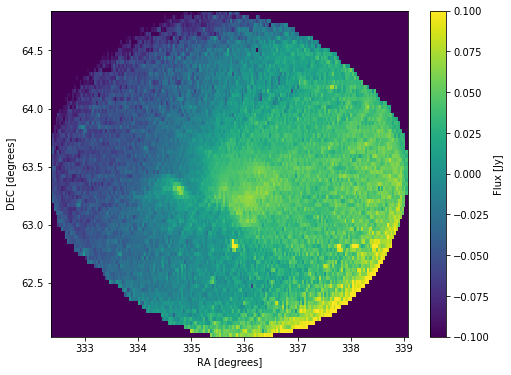

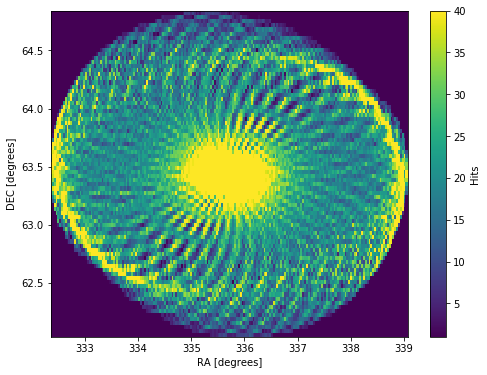

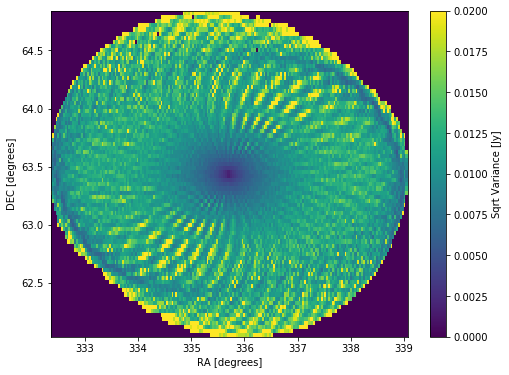

In [20]:
rabins, decbins, signal, hits, varmap = get_maps('C', 5)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide


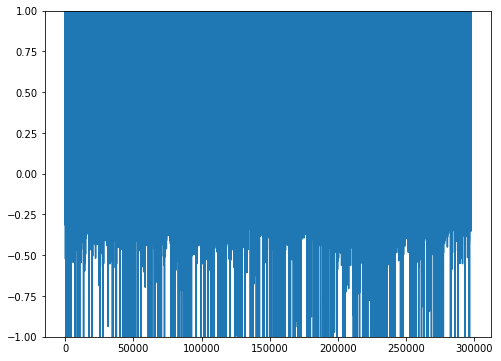

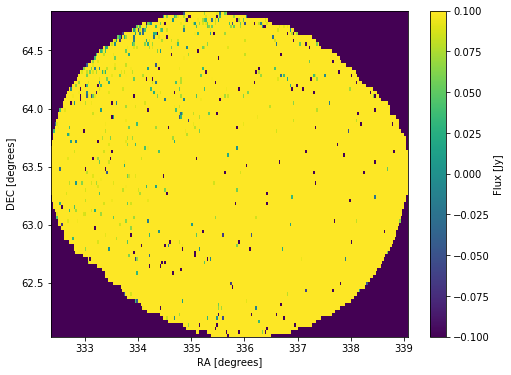

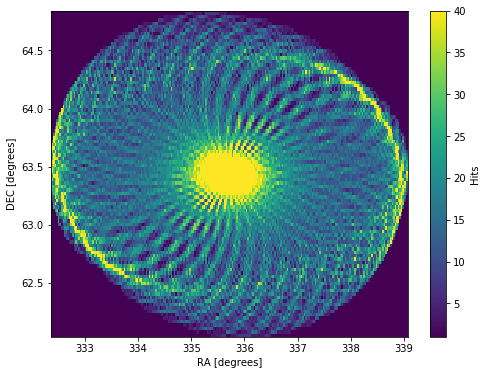

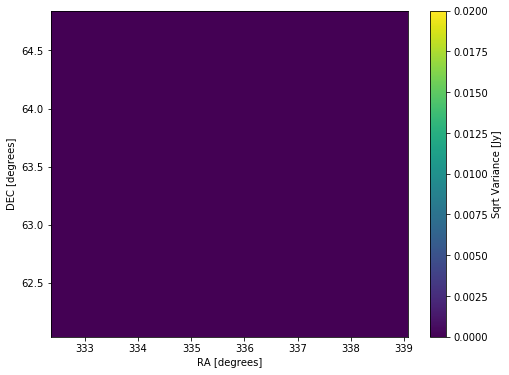

In [26]:
rabins, decbins, signal, hits, varmap, calibrated = get_maps('D', 5)

(-10, 10)

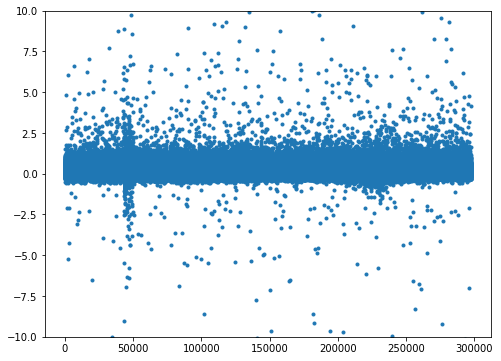

In [29]:
plot(calibrated, '.')
ylim(-10, 10)

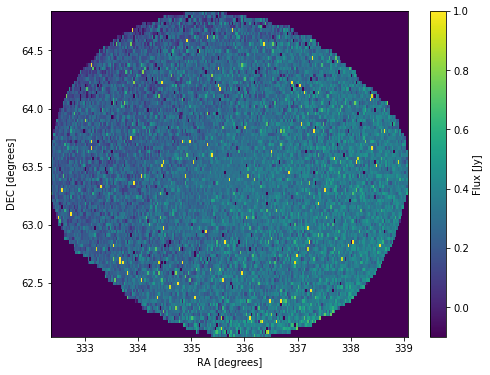

In [24]:
pc = pcolormesh(rabins, decbins, signal)
clim(-0.1, 1)
cb = colorbar()
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


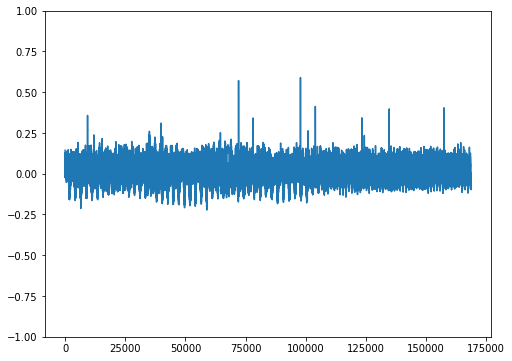

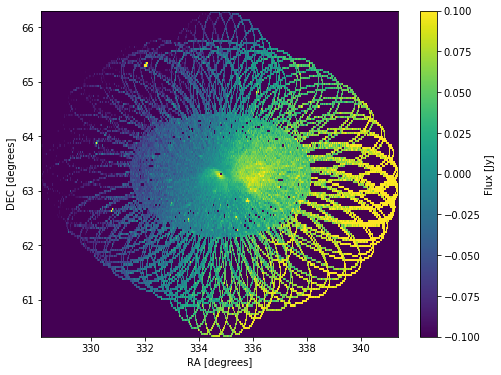

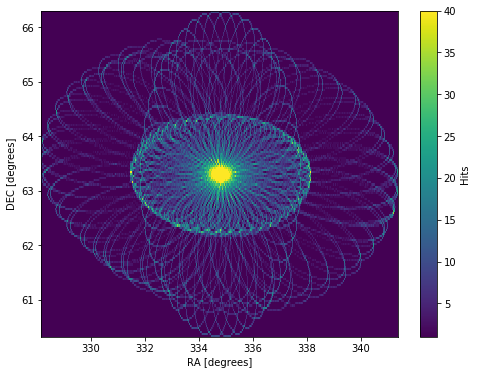

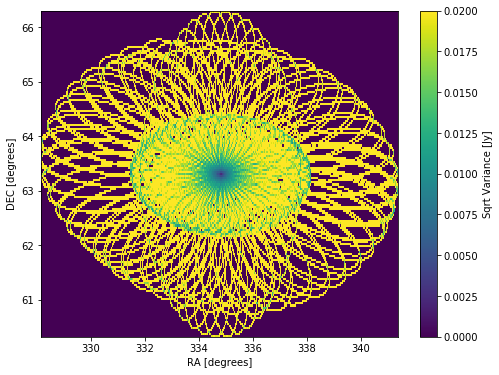

In [44]:
rabins, decbins, signal, hits, varmap, calibrated = get_maps('B', 2)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


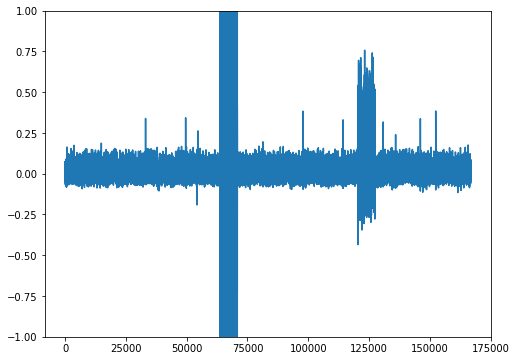

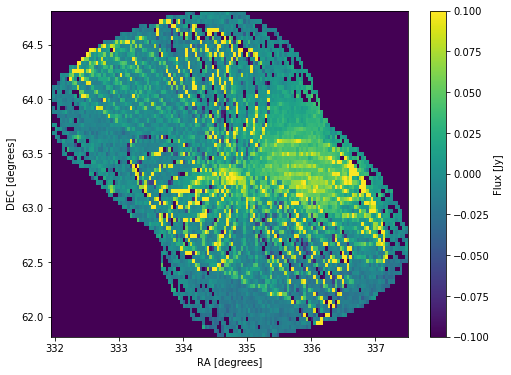

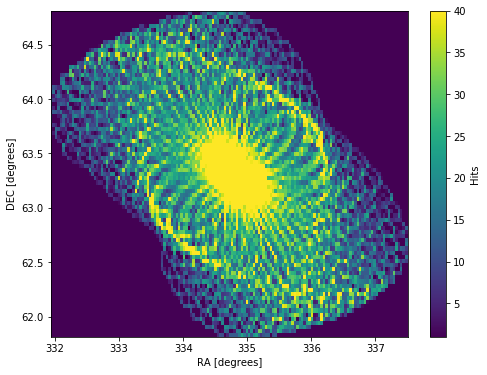

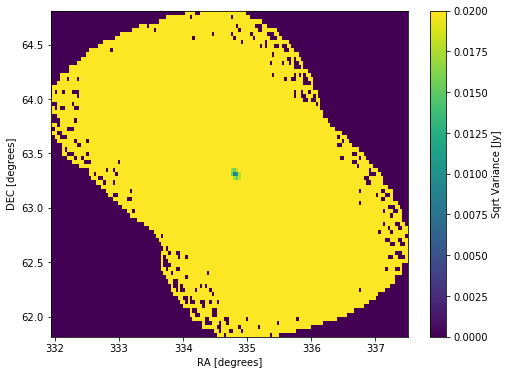

In [45]:
rabins, decbins, signal, hits, varmap, calibrated = get_maps('B', 3)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in divide
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in divide


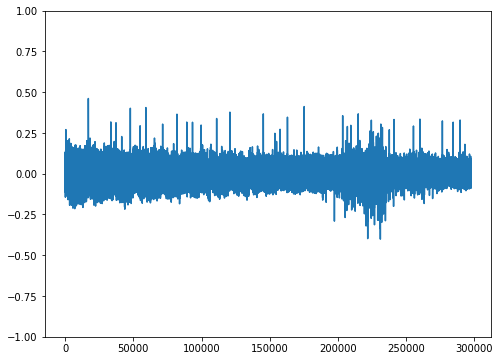

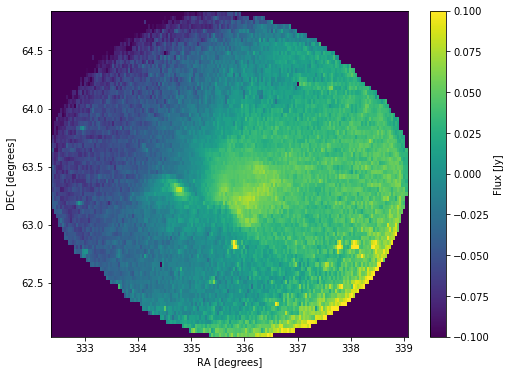

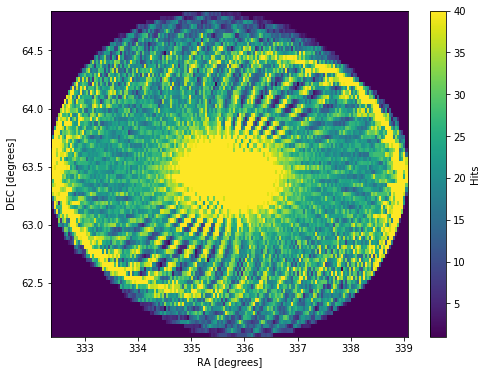

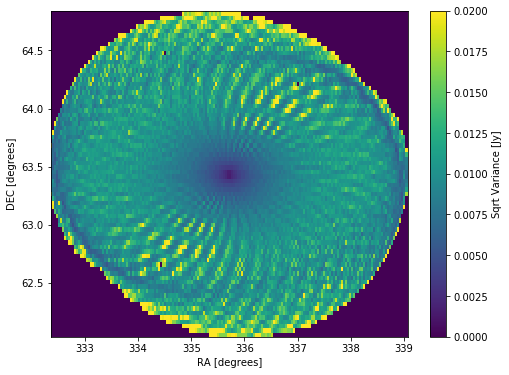

In [46]:
rabins, decbins, signal, hits, varmap, calibrated = get_maps('B', 5)